# Best Artworks Of All Time

<p style='text-align: right;'> <em> Roman Gorb,<br/>gorb.roman1999@gmail.com</em> </p>

In this work I will try to solve artist classification problem based on [**"Best Artworks Of All Time"**](https://www.kaggle.com/ikarus777/best-artworks-of-all-time) dataset using `TensorFlow 2.0`. 

**Dataset description**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.
I gathered a collection of artworks of the 50 most influential artists of all time. I added a dataset with basic information retrieved from wikipedia. I planned to create a convolutional neural network to recognise the artists looking the colors used and the geometric patterns inside the pictures.

**Content**

This dataset contains three files:

* `artists.csv`: dataset of information for each artist
* `images.zip`: collection of images (full size), divided in folders and sequentially numbered
* `resized.zip`: same collection but images have been resized and extracted from folder structure

Use resized.zip allows you to download less data and process faster your model.

**Inspiration**

My goal is to create a model that learn to identify the artist analysing new pictures. I hope to learn new techniques from public kernels or see some interesting usage of this data.

![](https://sun9-51.userapi.com/c858136/v858136162/1c0b61/GwA18z9fPIg.jpg)

In [18]:
# Imports
import datetime
import os
import pathlib
import random
import shutil

from conf import *
from stats import *

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

STORAGE_DIR = '/data/rvgorb/hw10'

import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, Dense, Dropout, Flatten,
                                     MaxPooling2D, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

%load_ext tensorboard

AUTOTUNE = tf.data.experimental.AUTOTUNE

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Loading and exploring the data

In [6]:
# Data loading and extracting

# !wget -O /data/rvgorb/hw10/data.tar.xz https://www.dropbox.com/s/w90m55pl7ylgiaf/data.tar.xz?dl=0
# !tar -xf /data/rvgorb/hw10/data.tar.xz data
!ls /data/rvgorb/hw10/data/train | wc -l
!find /data/rvgorb/hw10/data/train -type f | wc -l

50
4099


In `train` data we have 51 artists(labels) and 6116 paintings(samples).

Let's have a look on our data:

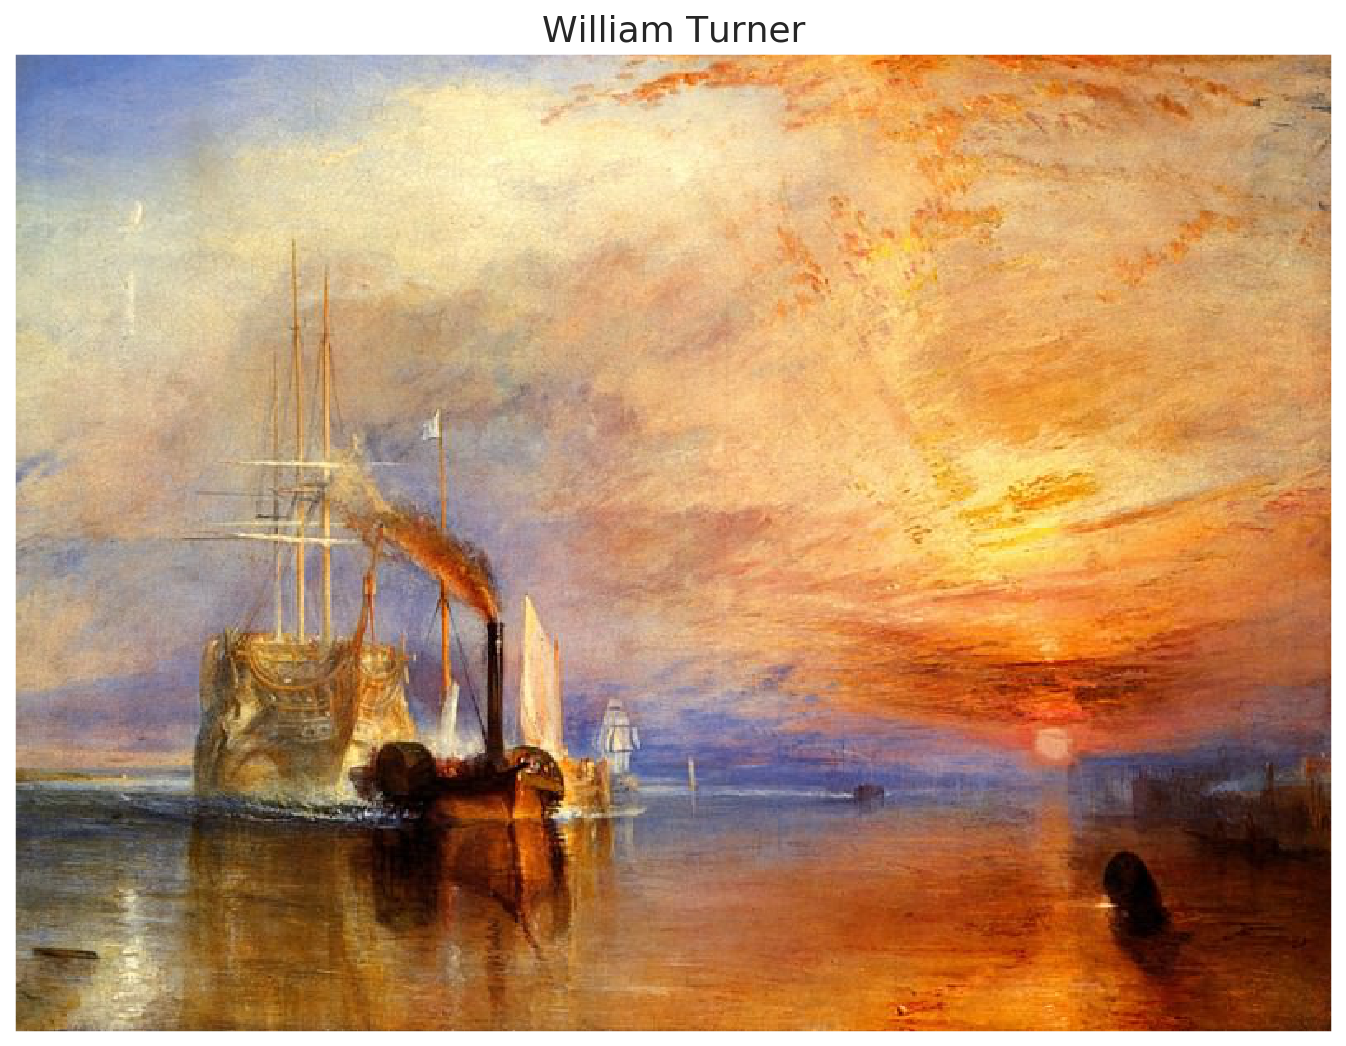

In [12]:
# Visualization
fig = plt.figure(figsize=(16, 9))
ax = fig.gca()
path_to_img = f'{STORAGE_DIR}/data/train/William_Turner/William_Turner_9.jpg'
image = plt.imread(path_to_img)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.title('William Turner')
_ = plt.imshow(image)

Processing `train/val` split:

In [8]:
# Train/val split
os.makedirs(f'{STORAGE_DIR}/data/val', exist_ok=True)

TRAIN_FRAC = 0.7

# reading dir's names
ARTIST_LIST = {i:name for i, name in enumerate(os.listdir(f'{STORAGE_DIR}/data/train/'))}
IMAGES_DIR = f'{STORAGE_DIR}/data/train/'

max_train_images = 0

for artist in ARTIST_LIST.values():
    # preparing dir for every artist
    os.makedirs(f'{STORAGE_DIR}/data/val/{artist}/', exist_ok=True)

    # loading paths
    artist_path = f'{IMAGES_DIR}/{artist}/'
    images_filename = os.listdir(artist_path)
    
    # processing split
    num_train = int(len(images_filename) * TRAIN_FRAC)
    max_train_images = max(max_train_images, num_train)
    val_images = images_filename[num_train:]

    print(f'{artist} | train images = {num_train} | val images = {len(val_images)}')
    
    # saving to directory
    for image_filename in val_images:
        source = f'{IMAGES_DIR}/{artist}/{image_filename}'
        destination = f'{STORAGE_DIR}/data/val/{artist}/{image_filename}'
        shutil.copy(source, destination)
        os.remove(source)

Kazimir_Malevich | train images = 61 | val images = 27
Henri_Rousseau | train images = 34 | val images = 15
Hieronymus_Bosch | train images = 66 | val images = 29
Joan_Miro | train images = 49 | val images = 22
Giotto_di_Bondone | train images = 58 | val images = 25
Michelangelo | train images = 23 | val images = 11
Paul_Cezanne | train images = 22 | val images = 10
Paul_Gauguin | train images = 151 | val images = 66
Andrei_Rublev | train images = 48 | val images = 21
Mikhail_Vrubel | train images = 83 | val images = 36
Eugene_Delacroix | train images = 14 | val images = 7
Claude_Monet | train images = 35 | val images = 16
Edouard_Manet | train images = 43 | val images = 19
Jackson_Pollock | train images = 11 | val images = 5
Marc_Chagall | train images = 116 | val images = 51
Francisco_Goya | train images = 142 | val images = 61
Camille_Pissarro | train images = 44 | val images = 19
Alfred_Sisley | train images = 126 | val images = 55
Titian | train images = 124 | val images = 54
Gust

**Note:**

> * As you can see, there are two copies of Albrecht Dürer directory, so we should remove one duplicate.

In [9]:
# Removing duplicates
!rm -rf /data/rvgorb/hw10/data/train/Albrecht_DuтХа├кrer/
!rm -rf /data/rvgorb/hw10/data/val/Albrecht_DuтХа├кrer/
!rm -rf /data/rvgorb/hw10/data/test/Albrecht_DuтХа├кrer/
del ARTIST_LIST[33]

In [10]:
# Sanity check
!ls /data/rvgorb/hw10/data/train | wc -l
!ls /data/rvgorb/hw10/data/val | wc -l
!ls /data/rvgorb/hw10/data/test | wc -l

50
50
50


Checking that class balances on train, val and test data match:

In [11]:
# Ratious calculation
ratious_val = []
ratious_train = []

for artist in ARTIST_LIST.values():
    train_dir = f'{STORAGE_DIR}/data/train/{artist}'
    filenames = os.listdir(train_dir)
    num_train = len(filenames)
    
    test_dir = f'{STORAGE_DIR}/data/test/{artist}'
    filenames = os.listdir(test_dir)
    num_test = len(filenames)
    
    val_dir = f'{STORAGE_DIR}/data/val/{artist}'
    filenames = os.listdir(val_dir)
    num_val = len(filenames)
    
    ratious_val.append(num_test / num_val)
    ratious_train.append(num_test / num_train)

ratious_val = np.array(ratious_val)
ratious_train = np.array(ratious_train)

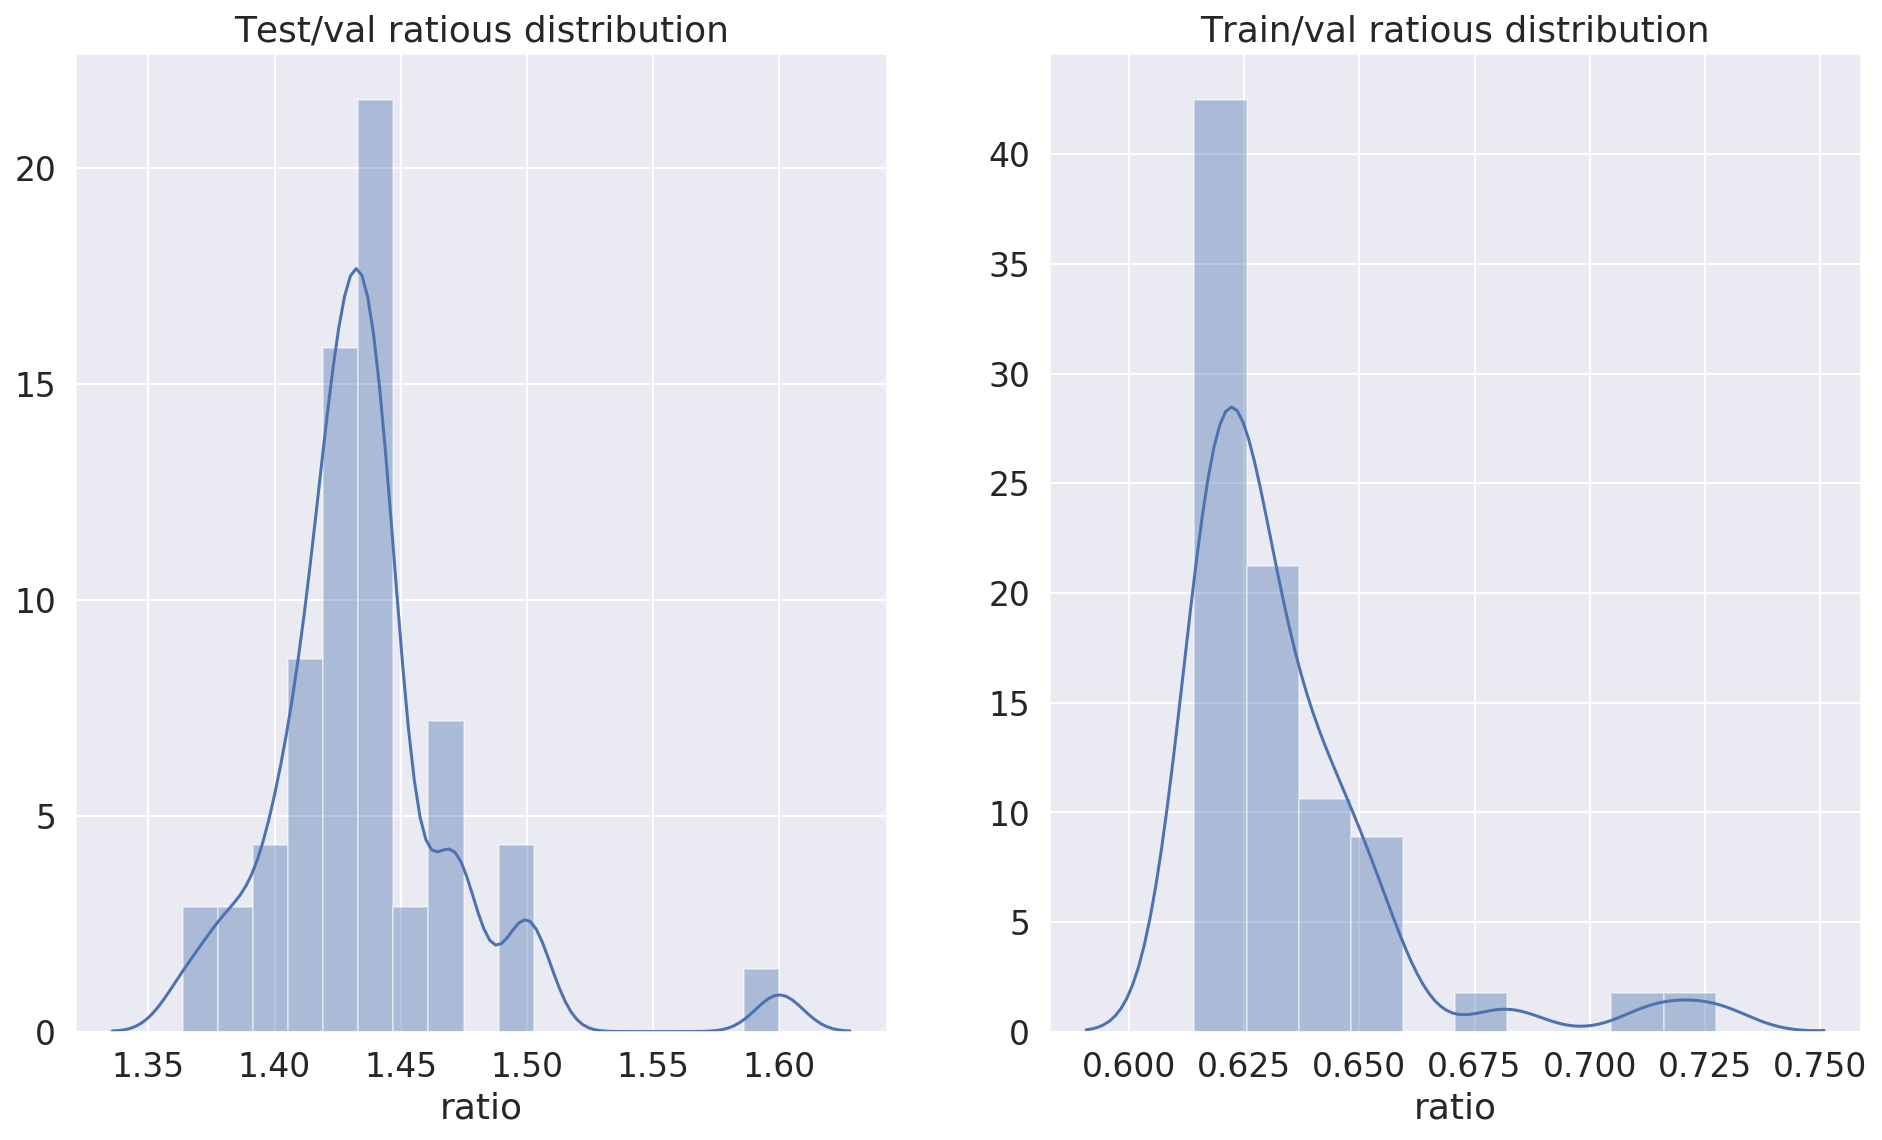

In [12]:
# Visualization
plt.figure(figsize=(16, 9))

plt.subplot(1, 2, 1)
sns.distplot(ratious_val)
plt.title('Test/val ratious distribution')
_ = plt.xlabel('ratio')

plt.subplot(1, 2, 2)
sns.distplot(ratious_train)
plt.title('Train/val ratious distribution')
_ = plt.xlabel('ratio')

**Conclusions:**

> * The ratious are mostly the same, that is why we can say that the splits are equally distributed.

This classification task is unbalanced, and there are some ways to deal with this problem:

* Random oversampling – creating copies of samples in minority classes.
* Random undersampling – drop samples from major classes.
* Do both to achieve the same number of pictures in each class.

You can find the method combining this ideas further. I tried to use this techniques, but they did not help me in my particular task.

But in this work I will mostly concentrate on the accuracy maximization, therefore there is no need to worry about the classes balance(which of course is not true when we consider e.g. $F_1\text{-score}$).

In [13]:
def under_over_sample(directory: str, level: int) -> None:
    filenames = os.listdir(directory)
    num_files = len(filenames)
    
    if num_files < level:
        # over sample
        num_add = level - num_files
        indexes_to_add = np.random.choice(num_files, size=num_add)
        for i, ind in enumerate(indexes_to_add):
            name = filenames[ind]
            source = f'{directory}/{name}'
            dest = f'{directory}/{name}_{i}'
            shutil.copy(source, dest)
    else:
        # under sample
        num_remove = num_files - level
        indexes_to_remove = np.random.choice(num_files, size=num_remove, replace=False)
        for ind in indexes_to_remove:
            name = filenames[ind]
            file = f'{directory}/{name}'
            os.remove(file)
    
    filenames = os.listdir(directory)
    num_files = len(filenames)
    assert num_files == level, "WTF"  # sanity check

In [14]:
# Under/over sampling
# NUM_TRAIN = 200

# for artist in ARTIST_LIST.values():
#     train_dir = f'{STORAGE_DIR}/data/train/{artist}'
#     under_over_sample(train_dir, level=NUM_TRAIN)

## Creating datasets

This part of work concetrates on network input data preparation.

In [31]:
# Paths config
train_dir = f'{STORAGE_DIR}/data/train/'
val_dir = f'{STORAGE_DIR}/data/val/'
test_dir = f'{STORAGE_DIR}/data/test/'

Implementing some custom augmentations(but I do not use them all in this work):

In [ ]:
# Custom augmentations
def pad_if_needed(img_tensor, sz=224):
    h, w = img_tensor.shape.as_list()[-3:-1]
    diff = tf.constant([sz, sz]) - tf.constant([h, w])

    need_pad = tf.math.maximum(diff, tf.zeros(2, dtype=tf.int32))
    need_pad = need_pad.numpy()

    pad_x = need_pad[0] // 2
    pad_y = need_pad[1] // 2

    return tf.pad(img_tensor,
                  tf.constant([[pad_x, need_pad[0] - pad_x],
                               [pad_y, need_pad[1] - pad_y], [0, 0]]),
                  mode='SYMMETRIC')


def center_crop(img_tensor, sz=224):
    assert sz % 2 == 0, 'sz should be even'

    h, w = img_tensor.shape.as_list()[-3:-1]
    c_h = h // 2
    c_w = w // 2

    return tf.image.crop_to_bounding_box(img_tensor, c_h - sz // 2,
                                         c_w - sz // 2, sz, sz)


def normalize(img_tensor, means=[0.485, 0.456, 0.406], stds=[0.229, 0.224, 0.225]):
    mean = tf.constant(means, dtype=tf.float32)
    mean = tf.reshape(mean, [1, 1, 3])
    std = tf.constant(stds, dtype=tf.float32)
    std = tf.reshape(std, [1, 1, 3])
    
    img_tensor = img_tensor - mean
    img_tensor = img_tensor / std
    
    return img_tensor


def random_sized_random_crop(img_tensor, min_ratio=0.5, max_ratio=1.):
    h, w = img_tensor.shape.as_list()[-3:-1]
    
    min_h = int(h * min_ratio)
    max_h = int(h * max_ratio)
    min_w = int(w * min_ratio)
    max_w = int(w * max_ratio)
    
    new_h = tf.random.uniform([], minval=min_h, maxval=max_h, dtype=tf.int32)
    new_w = tf.random.uniform([], minval=min_w, maxval=max_w, dtype=tf.int32)
    
    return tf.image.random_crop(img_tensor, (new_h, new_w, 3))

Creating `train/test` preprocessing pipelines:

In [37]:
# Image preprocessing
def preprocess_train_image(image, sz=224):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # zero center and normalize
    # image = tf.image.per_image_standardization(image)
    
    # custom normalization
    image = normalize(image)
    
    # handling small images
    # image = pad_if_needed(image)
    
    # horizontal flip
    image = tf.image.flip_left_right(image)
    
    # vertical flip
    # image = tf.image.flip_up_down(image)
    
    # brightness
    # image = tf.image.random_brightness(image, 0.5)
    
    # rotation
    # image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=-1, maxval=1, dtype=tf.int32))
    
    # random crop to sz x sz
    # image = tf.image.random_crop(image, size=[sz, sz, 3])
    
    # small noise
    # noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.0001, dtype=tf.float32)
    # image = image + noise
    
    # random crop of random size
    image = random_sized_random_crop(image, min_ratio=0.75)
    
    # resize
    image = tf.image.resize(image, (sz, sz), method=tf.image.ResizeMethod.LANCZOS5)
    
    return image


def preprocess_test_image(image, sz=224):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # zero center and normalize
    # image = tf.image.per_image_standardization(image)
    
    # custom normalization
    image = normalize(image)
    
    # handling small images
    # image = pad_if_needed(image)
    
    # random crop to 224x224
    # image = center_crop(image)
    
    # resize
    image = tf.image.resize(image, (sz, sz), method=tf.image.ResizeMethod.LANCZOS5)
    
    return image


def load_and_preprocess_train_image(path):
    image = tf.io.read_file(path)
    return preprocess_train_image(image)


def load_and_preprocess_test_image(path):
    image = tf.io.read_file(path)
    return preprocess_test_image(image)

Decorate them with tensorflow mappers:

In [38]:
# Mappers
train_mapper = lambda x: tf.py_function(
    func=load_and_preprocess_train_image, inp=[x], Tout=tf.float32)
test_mapper = lambda x: tf.py_function(
    func=load_and_preprocess_test_image, inp=[x], Tout=tf.float32)

Creating datasets:

In [39]:
def set_shapes(img, label, img_shape=(224, 224, 3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label


def create_dataset(dir_path, map_fn):
    root = pathlib.Path(dir_path)
    # Image paths parsing
    all_image_paths = list(root.glob('*/*'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)
    # Labels creation
    label_names = sorted(item.name for item in root.glob('*/')
                         if item.is_dir())
    label_to_index = dict(
        (name, index) for index, name in enumerate(label_names))
    global index_to_label
    index_to_label = dict((index, name) for index, name in enumerate(label_names))
    all_image_labels = [
        label_to_index[pathlib.Path(path).parent.name]
        for path in all_image_paths
    ]
    # Image dataset creation
    image_path_dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)
    image_dataset = image_path_dataset.map(map_fn, num_parallel_calls=AUTOTUNE)
    # Labels dataset creation
    label_dataset = tf.data.Dataset.from_tensor_slices(
        tf.cast(all_image_labels, tf.int64))
    # Image + Label dataset creation
    image_label_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

    image_label_dataset = image_label_dataset.map(
        lambda img, lavel: set_shapes(img, lavel))

    return image_label_dataset, len(all_image_paths), len(label_names)

In [40]:
image_label_train, train_size, labels_count = create_dataset(train_dir, train_mapper)
image_label_val, val_size, _ = create_dataset(val_dir, test_mapper)
image_label_test, test_size, _ = create_dataset(test_dir, test_mapper)

Let's look at network input:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


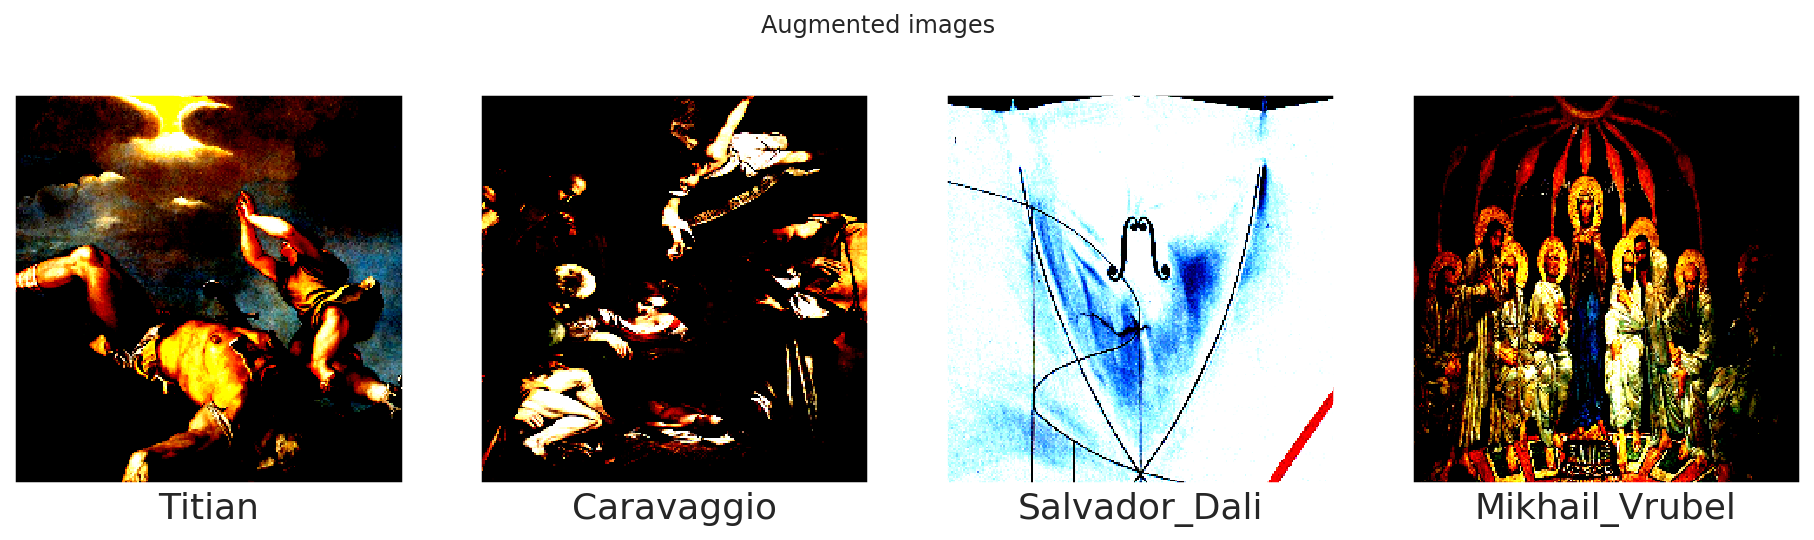

In [41]:
# Augmented images visualization
plt.figure(figsize=(16, 4))

for n, (image, label) in enumerate(image_label_train.take(4)):
    plt.subplot(1, 4, n + 1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(index_to_label[label.numpy()])

_ = plt.suptitle('Augmented images')

Preparing datasets for efficient training and validation:
* Using cache to improve performance(storing in RAM).
* Shuffling train.
* Repeating datasets to avoid their exhaustibility.
* Using batching to fit in GPU memory.
* Using prefetch to load data in parallel.

In [42]:
TRAIN_BATCH_SIZE = 64

ds_train = image_label_train.cache()
ds_train = ds_train.shuffle(buffer_size=train_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(TRAIN_BATCH_SIZE)
ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)

In [43]:
VAL_BATCH_SIZE = 64

ds_val = image_label_val.cache()
ds_val = ds_val.repeat()
ds_val = ds_val.batch(VAL_BATCH_SIZE)
ds_val = ds_val.prefetch(buffer_size=AUTOTUNE)

In [49]:
TEST_BATCH_SIZE = 64

ds_test = image_label_test.cache()
ds_test = ds_test.batch(VAL_BATCH_SIZE)
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)

### Conv net 

I tried something **as simple as possible**: repeated thrice a conv block and use dense with dropouts thereafter.

The architecture below was found by trial and error. To be honest, I trained about $80$ different models. You can find the report describing my story in the end of this section.

In [45]:
# Model architecture
model = Sequential([
    Conv2D(32,
           5,
           padding='same',
           activation='relu',
           strides=2,
           input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(strides=2, padding='same'),
    Conv2D(64, 3, padding='same', strides=2, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(strides=2, padding='same'),
    Conv2D(128, 3, padding='same', strides=2, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(strides=2, padding='same'),
    Flatten(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    # Dropout(0.35),
    Dense(labels_count, activation='softmax')
])

In [46]:
# Model compilation
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=7,
                              min_delta=0.01,
                              min_lr=1e-7,
                              verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=40,
                                                  min_delta=0.005,
                                                  verbose=1)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 112, 112, 32)      2432      
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)        

Using tensorboard to visualize training process:

In [27]:
tensorboard --logdir /data/rvgorb/hw10/logs/scalars/ --port 7775

Reusing TensorBoard on port 7775 (pid 5820), started 0:03:14 ago. (Use '!kill 5820' to kill it.)

Saved results:

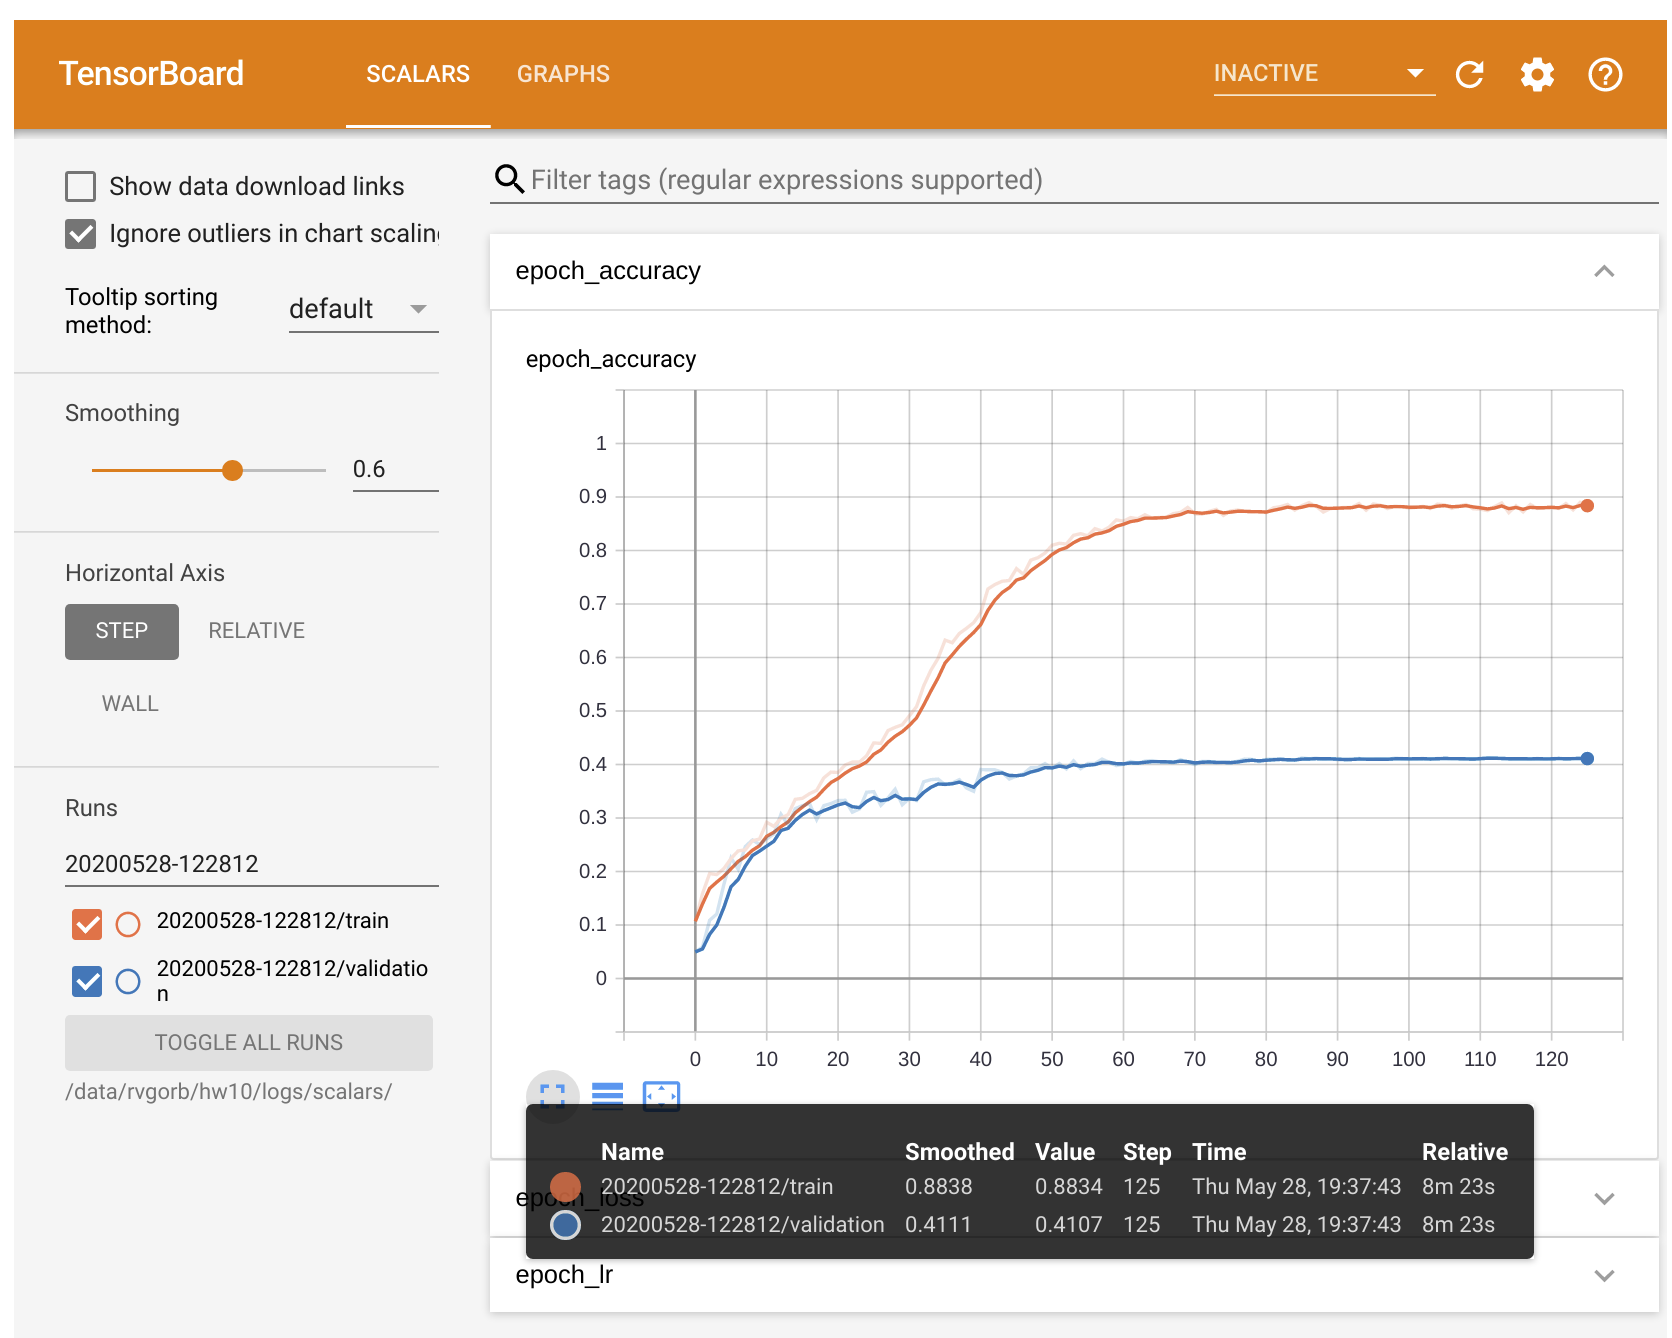

In [48]:
# My model fit
logdir = "/data/rvgorb/hw10/logs/scalars/" + datetime.datetime.now().strftime(
    "%Y%m%d-%H%M%S")
print("logdir:", logdir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

steps_per_epoch = int(tf.math.ceil(train_size / TRAIN_BATCH_SIZE).numpy())
validation_steps = int(tf.math.ceil(val_size / VAL_BATCH_SIZE).numpy())

model.fit(ds_train,
          epochs=300,
          validation_data=ds_val,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          callbacks=[reduce_lr, early_stopping, tensorboard_callback])

logdir: /data/rvgorb/hw10/logs/scalars/20200528-122812
Train for 65 steps, validate for 28 steps
Epoch 1/300
65/65 [==============================] - 68s 1s/step - loss: 4.3549 - accuracy: 0.1070 - val_loss: 4.2660 - val_accuracy: 0.0497
Epoch 2/300
65/65 [==============================] - 5s 79ms/step - loss: 3.3285 - accuracy: 0.1587 - val_loss: 3.8013 - val_accuracy: 0.0586
Epoch 3/300
65/65 [==============================] - 4s 59ms/step - loss: 3.2114 - accuracy: 0.1962 - val_loss: 3.7575 - val_accuracy: 0.1088
Epoch 4/300
65/65 [==============================] - 4s 60ms/step - loss: 3.1242 - accuracy: 0.1942 - val_loss: 3.5532 - val_accuracy: 0.1205
Epoch 5/300
65/65 [==============================] - 5s 71ms/step - loss: 3.0687 - accuracy: 0.2055 - val_loss: 3.2310 - val_accuracy: 0.1758
Epoch 6/300
65/65 [==============================] - 4s 62ms/step - loss: 2.9782 - accuracy: 0.2243 - val_loss: 3.0044 - val_accuracy: 0.2254
Epoch 7/300
65/65 [==============================] -

Calculating test quality:

In [50]:
test_accuracy = model.evaluate(ds_test)[1]

40/40 [==============================] - 25s 631ms/step - loss: 3.0680 - accuracy: 0.4017


Results:

In [16]:
def print_result(test_accuracy):
    print("Test result:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

    if test_accuracy * 100 > 40:
        print("Achievement unlocked: ResNet152!")
    elif test_accuracy * 100 > 35:
        print("Achievement unlocked: Inception V3!")
    elif test_accuracy * 100 > 30:
        print("Achievement unlocked: AlexNet!")
    elif test_accuracy * 100 > 25:
        print("Achievement unlocked: MLP!")
    else:
        print("We need more \"layers\"! Follow instructons below")

In [17]:
print_result(test_accuracy)

Test result:
  test accuracy:		40.17 %
Achievement unlocked: ResNet152!


In [53]:
# Saving model
model.save('/data/rvgorb/hw10/my-final')

INFO:tensorflow:Assets written to: /data/rvgorb/hw10/my-final/assets


**Report:**

> It all started with conv blocks, I mean:
    - `Conv2d`
    - `ReLU`
    - `BatchNorm`
    - `MaxPooling2d`
Of course, after that I added dense layers with activations.
<br><br>
From the very beginning to almost the end I used `RandomCrop(224, 224)`(along with others), because it seemed incredibly logical to be. Let me explain. Many artists stand out in their style details: unique strokes, paint technique(e.g. impressionism), color tones and so on. Anyway we have to reduct image dimensionality to feed it into the network. So, if we want to save minute details of the painting we have to use only crops not rescaling. But to my surprise, I did not managed to achieve high score with this model.
<br><br>
After several hours, I decided to replace crop with resize and badum-ts! I got got significant improvement on validation and test. But still the main problem I fought with was the overfitting: models was getting $\approx 100\%$ on `train-e` and only $\approx37\%$ on validation.
<br><br>
Another main improvement was to use `RandomCrop` to select some large subpart of the image(not $224\times 224$). It brought significant variety to training data and reduced overfitting.
<br><br>
I have done about $80$ fits of the models to(in chronological order):
    - pick up conv blocks parameters to achieve overfitting
    - reduce overfitting
I applied augmentations, but the models were **not training** after that:
    - per image standartization
    - brightness adjust
    - adding small gaussian noise
I added dropouts and used large size crop and rescaling and after that I got current results.
<br><br>
After two days of work, I got this results(model `20200528-122812`):
* accuracy on training: $88.3\%$
* accuracy on validation: $41\%$
* accuracy on test: $40.2\%$

## Transfer Learning

Now, I want to use pretrained on imagenet `ResNet50`:

In [77]:
# Model loading
resnet_base = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                                include_top=False,
                                                weights='imagenet')

resnet_base.trainable = True

from_layer = 187 # resnet-50 has 50 blocks, not layers

for layer in resnet_base.layers[:from_layer]:
    layer.trainable =  False

In [78]:
class Wrapper(tf.keras.Model):
    def __init__(self, base_model):
        super(Wrapper, self).__init__()
        
        self.base_model = base_model
        self.average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(50, activation='softmax')
        
    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.average_pooling_layer(x)
        output = self.output_layer(x)
        return output

In [79]:
# Model compilation
base_learning_rate = 1e-5

resnet = Wrapper(resnet_base)
resnet.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [140]:
tensorboard --logdir /data/rvgorb/hw10/logs/scalars/ --port 7775

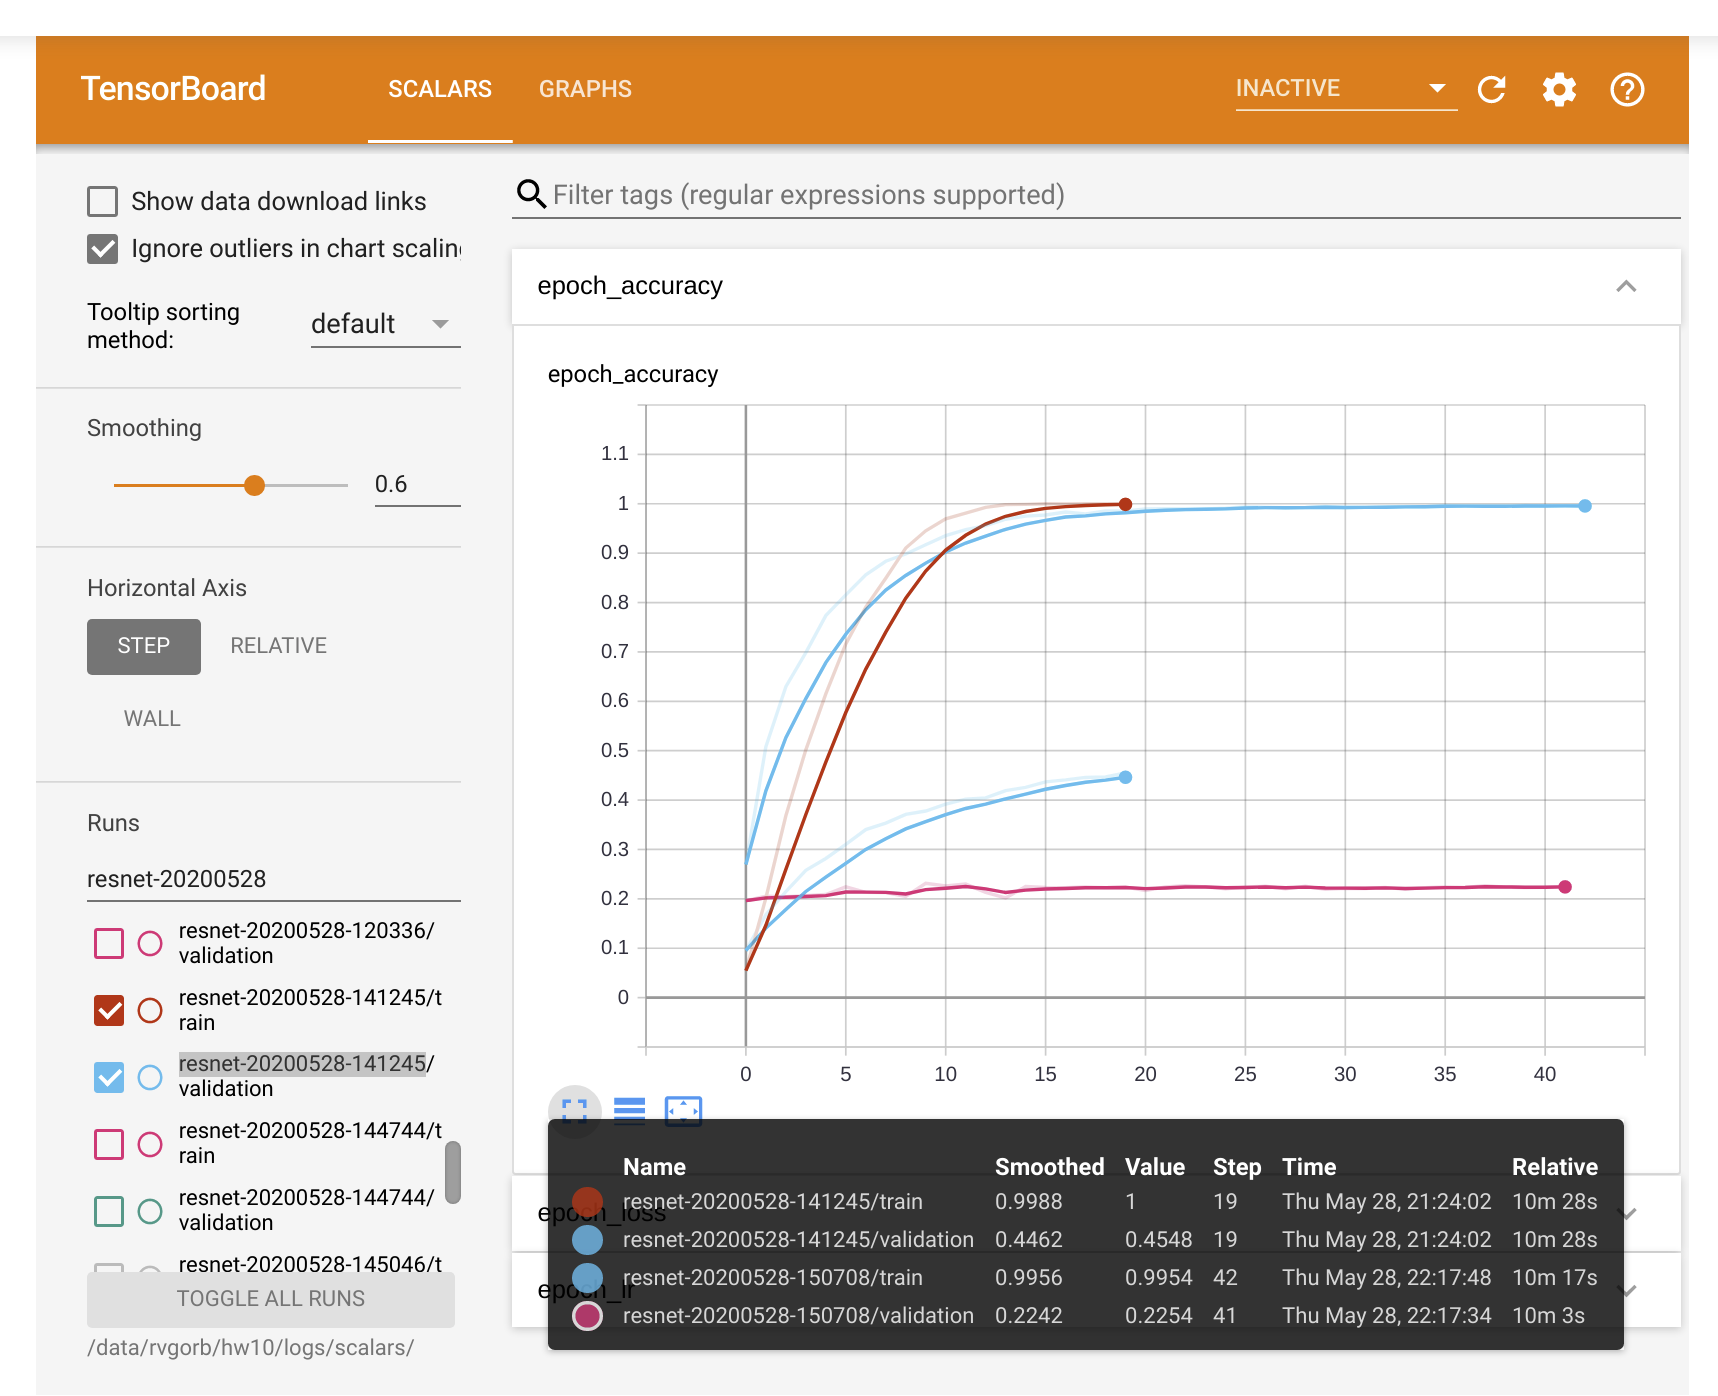

In [80]:
# Model training
logdir = "/data/rvgorb/hw10/logs/scalars/resnet-" + datetime.datetime.now(
).strftime("%Y%m%d-%H%M%S")
print('logdir:', logdir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history = resnet.fit(
    ds_train,
    epochs=20,
    validation_data=ds_val,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[tensorboard_callback, early_stopping, reduce_lr])

logdir: /data/rvgorb/hw10/logs/scalars/resnet-20200528-150708
Train for 65 steps, validate for 28 steps
Epoch 1/300
65/65 [==============================] - 19s 285ms/step - loss: 2.9220 - accuracy: 0.2695 - val_loss: 4.4859 - val_accuracy: 0.1964
Epoch 2/300
65/65 [==============================] - 15s 234ms/step - loss: 1.8550 - accuracy: 0.5082 - val_loss: 5.3787 - val_accuracy: 0.2054
Epoch 3/300
65/65 [==============================] - 15s 232ms/step - loss: 1.3980 - accuracy: 0.6298 - val_loss: 6.1948 - val_accuracy: 0.2042
Epoch 4/300
65/65 [==============================] - 14s 220ms/step - loss: 1.1147 - accuracy: 0.6986 - val_loss: 6.6686 - val_accuracy: 0.2065
Epoch 5/300
65/65 [==============================] - 14s 219ms/step - loss: 0.8979 - accuracy: 0.7736 - val_loss: 6.9854 - val_accuracy: 0.2087
Epoch 6/300
65/65 [==============================] - 15s 233ms/step - loss: 0.7392 - accuracy: 0.8154 - val_loss: 7.3262 - val_accuracy: 0.2243
Epoch 7/300
65/65 [=============

KeyboardInterrupt: 

In [61]:
resnet.save('/data/rvgorb/hw10/resnet-50-fine-tuned')

INFO:tensorflow:Assets written to: /data/rvgorb/hw10/resnet-50-fine-tuned/assets


In [63]:
test_accuracy = resnet.evaluate(ds_test)[1]

40/40 [==============================] - 6s 152ms/step - loss: 2.1067 - accuracy: 0.4662


In [64]:
# Results
print("Итоговый результат:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: Transformer!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: LSTM!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: RNN!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: perceptron!")
else:
    print("We need more \"layers\"! Follow instructons below")

Итоговый результат:
  test accuracy:		46.62 %
Achievement unlocked: Transformer!


Comparing with my model:

In [81]:
tensorboard --logdir /data/rvgorb/hw10/logs/scalars/ --port 7775

Reusing TensorBoard on port 7775 (pid 5820), started 3:50:50 ago. (Use '!kill 5820' to kill it.)

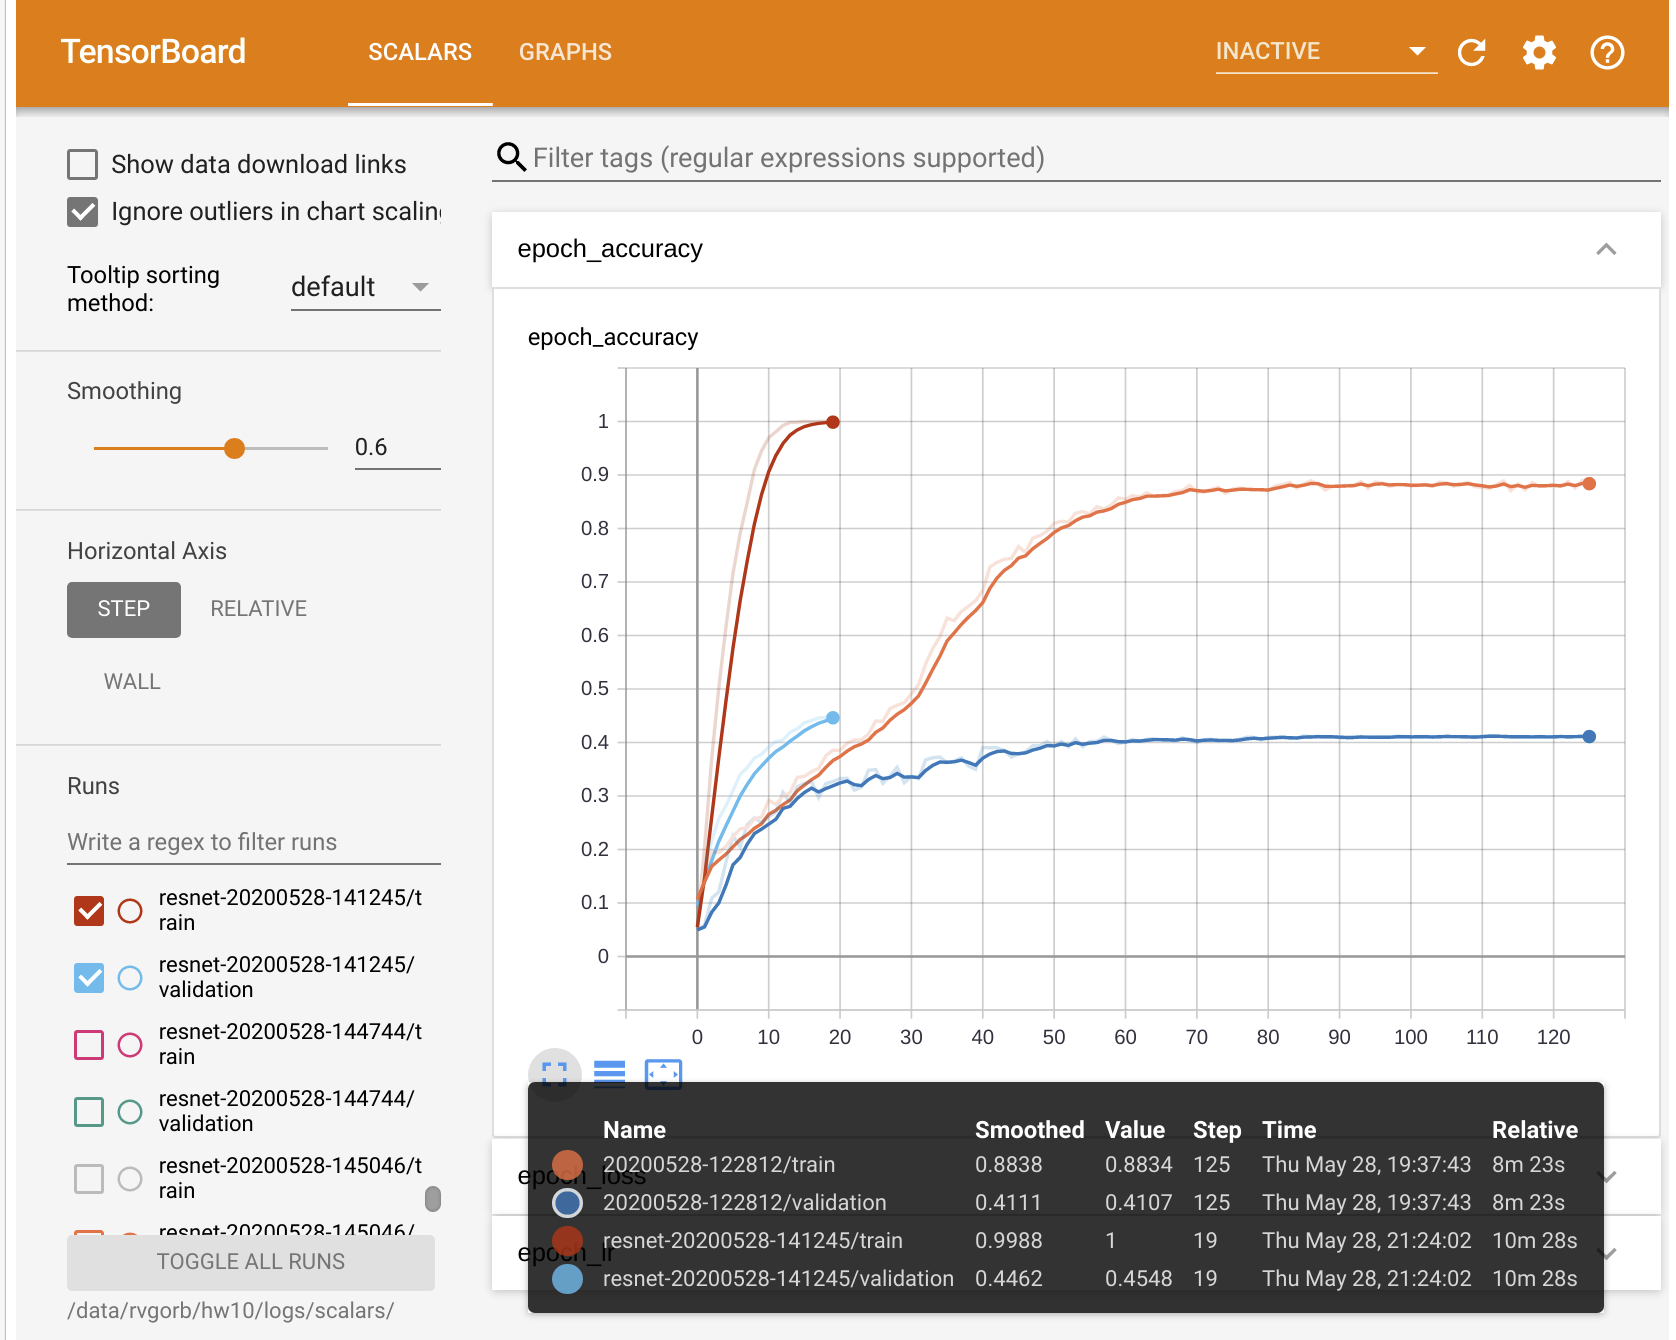

**Conclusions:**

> As you can see, using _transfer learning_ with minimum effort we achieved better results, so when you solving new task, a good way to do it is to find similar task with pretrained model and fine-tune it.